### Import libraries

In [72]:
import pandas as pd 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline
matplotlib.rcParams["figure.figsize"]=(20,10)
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.tree import DecisionTreeRegressor
import pickle

In [2]:
# loading dataset
df=pd.read_csv("Bengaluru_House_Data.csv")
df.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00


In [3]:
# check the number of cols and rows
df.shape

(13320, 9)

In [4]:
# knowing the data in area type
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
# remove unuseful columns (don't affect on the price )
df=df.drop(["area_type","availability","society","balcony"],axis="columns")
df.shape

(13320, 5)

### Data Cleaning

In [6]:
# check for null values
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
## the missing values is small so we can remove it 
df=df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
df.shape

(13246, 5)

In [9]:
# unique values in size columns
df["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
# make new column to hold the number of bhk
df["bhk"]=df["size"].apply(lambda x:int(x.split(' ')[0]))
df.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3


In [11]:
df["bhk"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [12]:
# check the values of total_sqft
df.total_sqft.unique()
# we find some values like a range

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [13]:
# find range values 
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [14]:
df[~df["total_sqft"].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [15]:
# take the average 
def convert_sqft_to_num(x):
    tokens=x.split("-")
    if len(tokens)==2:
        return(float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [16]:
## test function 
convert_sqft_to_num("55")

55.0

In [17]:
## test
convert_sqft_to_num("2100 - 2850")

2475.0

In [18]:
df["total_sqft"]=df["total_sqft"].apply(convert_sqft_to_num)


In [19]:
df.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


### Feature engineering

In [20]:
# make anew column (price per sqft)
df["price_per_sqft"]=df["price"]*100000/df["total_sqft"]
df.head(3)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556


In [21]:
# explore location
len(df.location.unique())

1304

In [22]:
df.location=df.location.apply(lambda x: x.strip())
location_stats=df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [23]:
# location states <10
len(location_stats[location_stats<=10])

1052

In [24]:
location_stats_less_than_10=location_stats[location_stats<=10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [25]:
df.location=df.location.apply(lambda x: "other" if x in location_stats_less_than_10 else x)
len(df.location.unique())
# so now we minimize the number of categories 

242

### Outliers detection

In [26]:
df[df.total_sqft/df.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [27]:
df.shape

(13246, 7)

In [28]:
# remove them
df=df[~(df.total_sqft/df.bhk<300)]
df.shape

(12502, 7)

In [29]:
# explore price 
df.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [30]:
def remove_pps_ouliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(m-st))&(subdf.price_per_sqft<=(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out    


In [31]:
df=remove_pps_ouliers(df)
df.shape

(10241, 7)

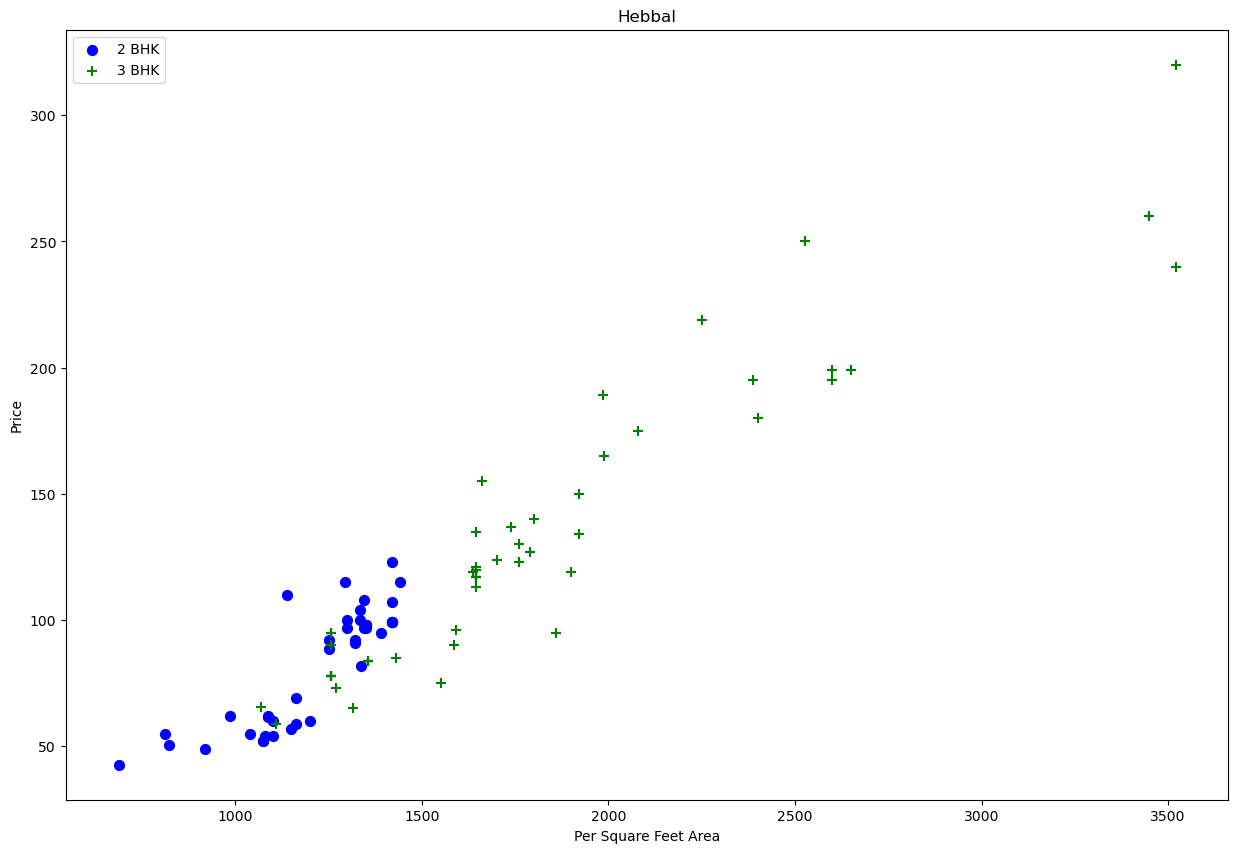

In [32]:
def plot_scatter_chart (df,location):
    bhk2=df[(df.location==location)&(df.bhk==2)]
    bhk3=df[(df.location==location)&(df.bhk==3)]
    matplotlib.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker="+",color='green',label='3 BHK',s=50)
    plt.xlabel("Per Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

plot_scatter_chart (df,"Hebbal")    
    

In [33]:
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location,location_df in df.groupby("location"):
        bhk_stats={}
        for bhk ,bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk]={
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
            }
        for bhk ,bhk_df in location_df.groupby('bhk'):
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis="index")       


In [34]:
df=remove_bhk_outliers(df)
df.shape

(7329, 7)

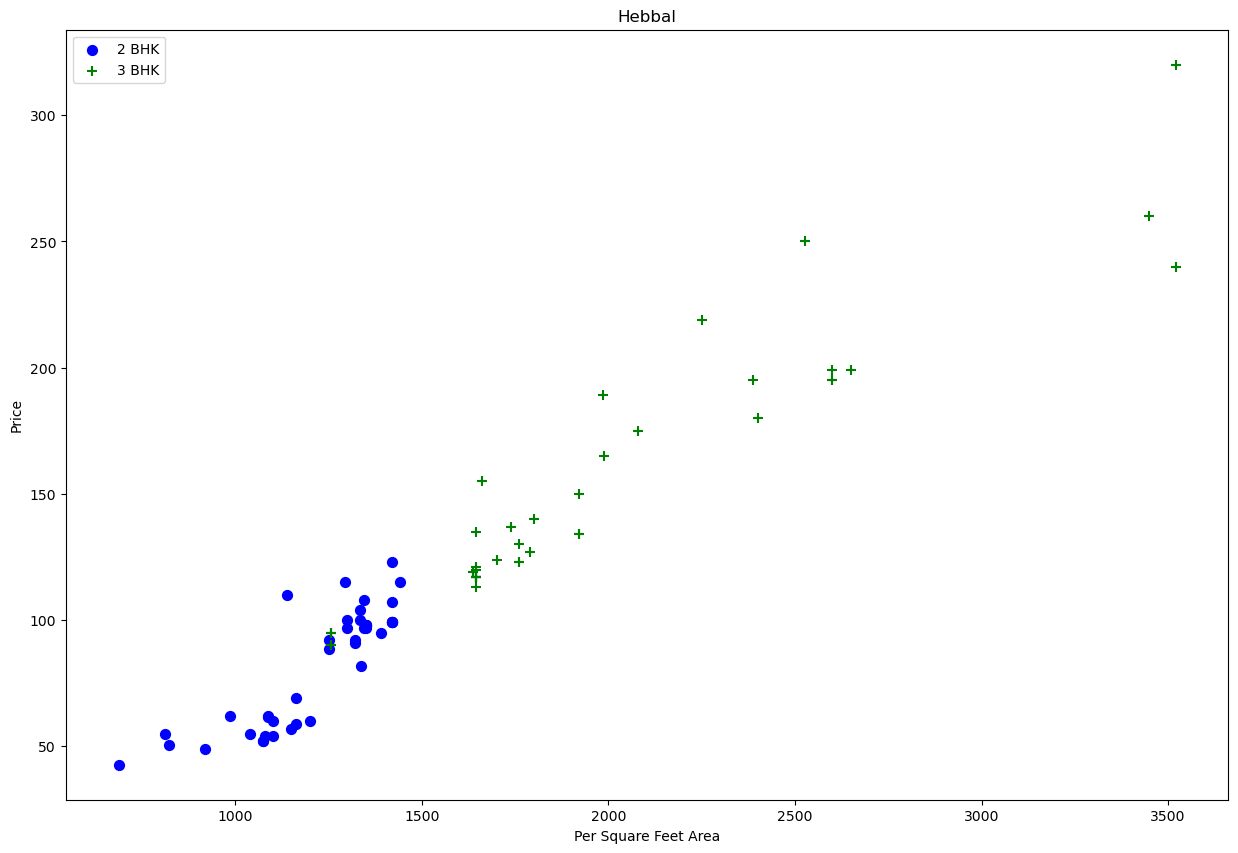

In [35]:
# check again
plot_scatter_chart (df,"Hebbal") 

Text(0, 0.5, 'Count')

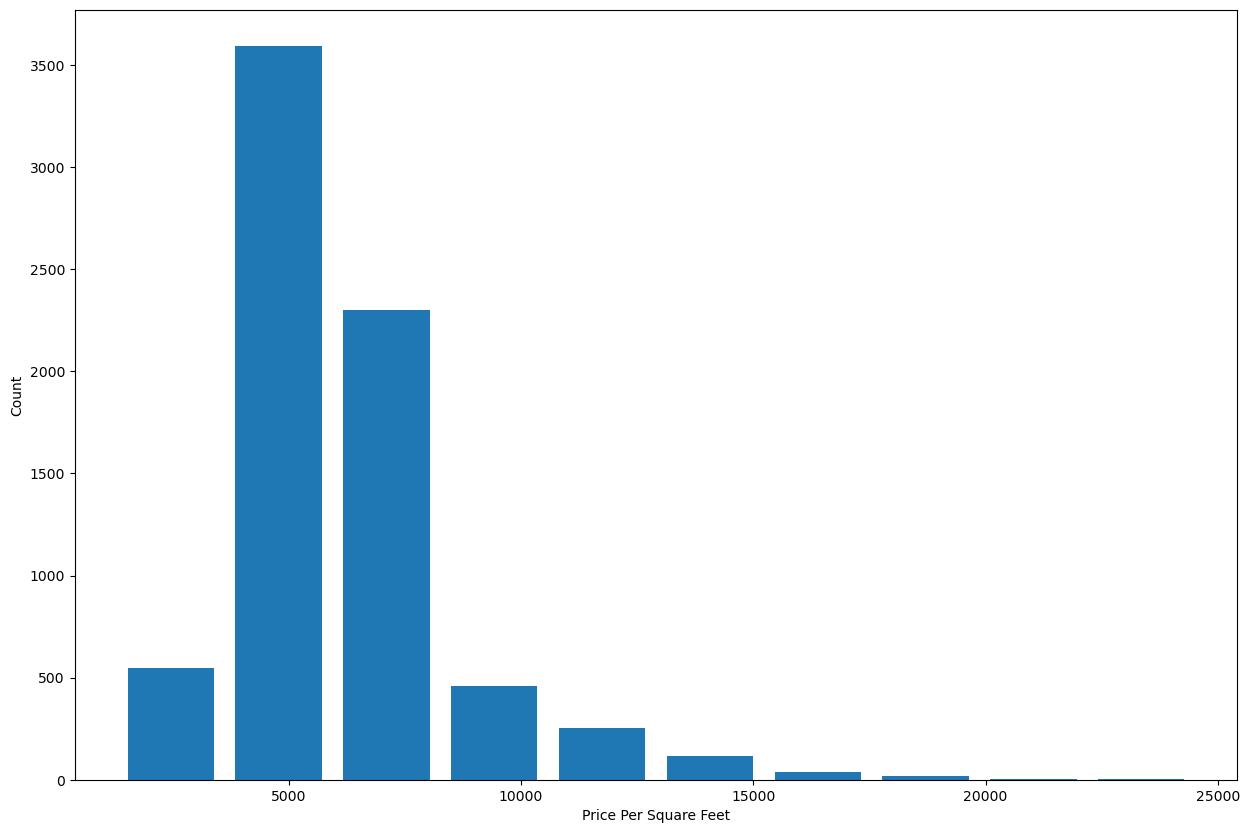

In [36]:
plt.hist(df.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
# the data is normal distribution

In [37]:
# explore bathroom
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [38]:
df[df.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

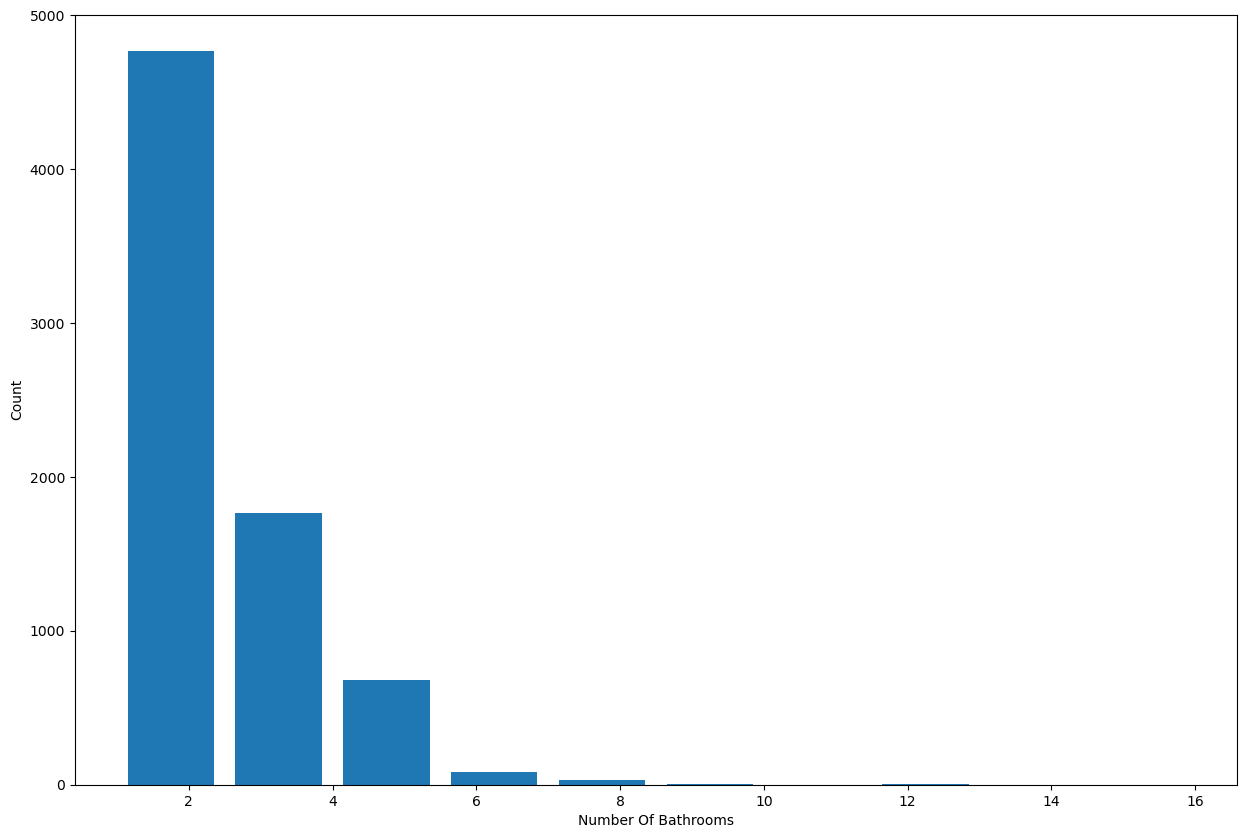

In [39]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number Of Bathrooms")
plt.ylabel("Count")

In [40]:
df[df.bath>df.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [41]:
# remove them
df=df[df.bath<df.bhk+2]
df.shape

(7251, 7)

In [42]:
df=df.drop(["size","price_per_sqft"],axis="columns")
df.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


### Machine learning model

In [43]:
# one hot encoding
dummies=pd.get_dummies(df.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df=pd.concat([df,dummies.drop("other",axis="columns")],axis="columns")
df.head(3)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df=df.drop("location",axis="columns")
df.head(3)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df.shape

(7251, 245)

In [47]:
X=df.drop("price",axis="columns")
y=df.price

In [54]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [55]:
#linearregression model

reg=LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.8452277697874279

In [57]:
# using cross validation
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [65]:
# using grid search cv
def find_best_model_using_gridsearchcv(X,y):
    algos={
        'linear_regression':{
            'model':LinearRegression(),
            'params':{
                #'normalize':[True,False]
            }
        },
        'lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random','cyclic']
            }
        },
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            "params":{
                'criterion':['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }
    }
    scores=[]
    cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name,config in algos.items():
        gs=GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_score':gs.best_score_,
            'best_params':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])  
find_best_model_using_gridsearchcv(X,y)    

D:\programs\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "D:\programs\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\programs\anaconda\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "D:\programs\anaconda\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "D:\programs\anaconda\lib\site-packages\sklearn\base.py", line 581, in _validate_pa

,model,best_score,best_params
0,linear_regression,0.818354,{}
1,lasso,0.687453,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.716753,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


## linear regression is the good one

In [66]:
### predict 
def predict_price(location,sqft,bath,bhk):
    loc_index=np.where(X.columns==location)[0][0]
    
    x=np.zeros(len(X.columns))
    x[0]=sqft
    x[1]=bath
    x[2]=bhk
    if loc_index>0:
        x[loc_index]=1
    return reg.predict([x])[0]    

In [67]:
predict_price('1st Phase JP Nagar',1000,2,2)

D:\programs\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.49904677167738

In [68]:
predict_price('1st Phase JP Nagar',1000,3,3)

D:\programs\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.80519395194304

In [70]:
predict_price('Indira Nagar',1000,2,2)

D:\programs\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


181.27815484007036

In [71]:
predict_price('Indira Nagar',1000,3,3)

D:\programs\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


184.584302020336

### Save model

In [74]:
with open('House_price.pickle','wb') as f:
    pickle.dump(reg,f)

In [75]:
import json
columns={
    'data_columns':[col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))